# Probabilistic Learning

Up to this point we have treated the target mapping as **deterministic**: for every input $x$ there is a single, correct output $y=f(x)$. That assumption is a drastic simplification. In realistic settings, solutions may be **ambiguous**, our learned model may **confuse** similar cases, and these effects often **interact**. This motivates a **probabilistic** treatment. Conceptually, we add a new axis to the problem: instead of a single outcome $y$, we consider a **distribution over possible outcomes** $p(y\mid x)$. Each candidate solution $y^{(i)}$ carries a probability weight $p(y^{(i)}\mid x)$ (often written simply as $p$), and samples $\{y^{(i)}\}$ drawn from this distribution should reflect those probabilities so that **rare** and **frequent** outcomes are distinguishable.

In short, rather than reasoning about a single solution $y$ per input, we reason about **many samples** $y^{(1)}, y^{(2)}, \dots$ from a distribution that captures both **variability** in the data and **uncertainty** in our model.

## Uncertainty

Every component of our pipelines—measurements, mechanistic models, and numerical solvers—introduces uncertainty. Sensors and clinical assays add **measurement error**. Mathematical models only describe a **subset** of the relevant physiology or physics, leaving the rest unmodeled. Discretization in simulations injects **numerical error**. In learning systems, the trained model itself contributes **approximation error**. Together these sources shape the **predictive uncertainty** of our outputs. For practical decision making, it is essential to **quantify** this uncertainty—one of the core reasons to work with probabilistic models and the central focus of **uncertainty quantification (UQ)**.

**Aleatoric vs. Epistemic Uncertainty.** It is common—though not always clean in practice—to separate predictive uncertainty into two broad types:

* **Aleatoric uncertainty** is **inherent variability in the data**, such as sensor noise, stochastic biological processes, or unobserved confounders. It persists even with infinite data.
* **Epistemic uncertainty** is **uncertainty about the model**—for example, due to limited training data, misspecified architectures, or poorly explored parameter regions. It can, in principle, be reduced by collecting more informative data.

A word of caution: this split is **idealized**. Effects may **overlap** and can be hard to disentangle. For instance, what looks like noisy outcomes (aleatoric) could stem from an overly coarse discretization or an inadequate hypothesis class (epistemic). In practice, the two often co-occur.

Closely related is the perspective of **simulation-based inference (SBI)**. Here the emphasis lies on estimating **likelihoods** or **posteriors** for models that are specified by **computer simulations** rather than analytic formulas. SBI offers a principled workflow for marrying simulators with uncertainty and will serve as a guiding thread in what follows.


## Forward or Backward?

It is crucial to distinguish **forward** from **inverse** (or “backward”) problems. Traditional numerical methods largely target **forward problems**: given a current state and parameters, compute a steady-state or future state of the system.

Many scientific and clinical questions, however, are **inverse problems**. A forward simulator is still central, but the unknowns are the **inputs or parameters** that best explain observed data. Formally, let a simulator $\mathcal{S}_\phi$ be parameterized by $\phi$ (e.g., viscosity, diffusion rates) and act on a state $x$ to produce an output $y=\mathcal{S}_\phi(x)$. We observe $y_{\text{obs}}$ and wish to infer $\phi$ (and, at times, parts of $x$) such that the simulator’s output matches the observation. In the simplest deterministic setting, this becomes an optimization problem

$$
\min_{\phi}\; \mathcal{L}\!\left(\mathcal{S}_\phi(x),\; y_{\text{obs}}\right).
$$

Solving it might reveal, for example, the viscosity of a specimen from rheology data. Similar inverse formulations arise across disciplines—from material science and fluid mechanics to neuroimaging and cosmology.

For clarity of notation, we will often **bundle** any state components we intend to estimate together with the parameters into a single vector $\theta$. We then “solve for $\theta$” while remembering that $\theta$ may include physical parameters, initial conditions, boundary terms, or latent states.

In what follows we emphasize **inverse problems** because they showcase the strengths of probabilistic modeling most directly. However, the algorithms we develop are **not limited** to inverse problems; we will point to forward-model applications as well.

## Simulation-Based Inference

In inverse settings, matching a **single** observation is rarely sufficient. We want a $\theta$ that explains a **range** of observations, we may entertain **multiple plausible** parameter values, and we often need to quantify how **uncertain** the estimate is. Are the data compatible with a **narrow** range of parameters, or could $\theta$ vary by **orders of magnitude** without materially degrading the fit? Addressing such questions requires **statistical inference**—characterizing a distribution over $\theta$ rather than a point estimate.

To connect with the aleatoric/epistemic split: in SBI we are primarily interrogating **uncertainty in the observations given a scientific hypothesis** encoded by a simulator. The simulator’s parameters $\theta$ are random variables we aim to infer.

Let $x$ denote the **inputs** to the simulator (which may include known states and controllable settings). Let $z$ denote **latent variables** capturing unknown or uncontrolled aspects of the system (e.g., unobserved stochasticity, intermediate steps, or random branches in the simulator’s control flow). We adopt the following generative story:

* Prior over parameters: $p(\theta)$.
* Prior over latents: $p(z)$ (potentially conditioned on $x$).
* Simulator outputs: $y=\mathcal{S}_\theta(x,z)$.

We observe $y_{\text{obs}}$ and seek the **posterior** over parameters

$$
p(\theta \mid x, y_{\text{obs}}) \;\propto\; p(y_{\text{obs}} \mid x, \theta)\, p(\theta).
$$

**Bayes’ theorem** underpins everything we do:

$$
p(\theta \mid x, y) \;=\; \frac{p(y \mid x, \theta)\, p(\theta)}{p(y \mid x)}.
$$

Both sides equal the joint $p(\theta, y \mid x)$ divided by the marginal $p(y \mid x)$.

The key building block is the **likelihood**

$$
p(y \mid x, \theta) \;=\; \int p\!\left(y \mid x, \theta, z\right)\, p(z)\, dz,
$$

the probability of seeing $y$ when the simulator is run at $\theta$ (marginalizing latent randomness $z$). This integral is often **intractable**: $z$ may be high-dimensional, hard to sample efficiently, or partly determined by opaque control flow. Classic estimators exist—**Approximate Bayesian Computation (ABC)** being a notable family—but they are **computationally heavy**, require careful summary statistics and distances, and suffer from the **curse of dimensionality**.

The denominator $p(y \mid x)$ is the **evidence** (or marginal likelihood):

$$
p(y \mid x) \;=\; \int p(y \mid x, \theta)\, p(\theta)\, d\theta.
$$

It normalizes the posterior. While the evidence need not be known to **sample** from the posterior (e.g., via MCMC, which uses ratios that cancel the evidence), estimating it can be useful for **model comparison**. In any case, computing likelihoods and evidences directly is rarely feasible for complex simulators, motivating learned approximations.


## Leveraging Deep Learning

This is where deep learning becomes especially powerful. We can **learn a conditional density estimator**

$$
q_\psi(\theta \mid x, y)
$$

that approximates the posterior and supports **fast sampling**. Crucially, we can train it using **simulated pairs** $(\theta, y)\sim p(\theta)\,p(z)\,\delta(y-\mathcal{S}_\theta(x,z))$, without requiring closed-form likelihoods.

To emphasize the probabilistic role of the network, we switch from writing $f_\theta$ for deterministic predictors to $q_\psi$ for **learned densities**. We will often start with **unconditional** density models $q_\psi(\theta)$ and then extend them to **conditional** forms $q_\psi(\theta \mid x,y)$.

**Pros of learned SBI approaches:**

* **Fast inference** after training: sampling or evaluating $q_\psi(\theta \mid x, y)$ is cheap.
* **Mitigated curse of dimensionality** relative to rejection-based ABC, via amortized, representation-rich models.
* **Flexible priors and posteriors:** compatible with complex, multimodal, or heavy-tailed distributions.

**Cons and caveats:**

* **Heavy upfront cost:** training requires many simulator runs and careful coverage of the parameter space.
* **Approximation gaps:** theoretical guarantees are weaker than in asymptotic MCMC; misspecification or limited simulations can bias the learned posterior.

We will develop a widely used and remarkably effective family of models—**diffusion-based methods**—for learning such densities. Rather than jumping straight to the final algorithm, we will build it from first principles, as the path introduces several influential ideas in modern machine learning. We will focus on the **core construction** here and return later to physics-aware variants that integrate **differentiable simulators**.


## Learning a Probability Distribution

A central question in probabilistic modeling is: **how can we learn an unknown probability distribution from data?** When prior knowledge is available, we can posit a **parametric family** (e.g., a Gaussian in the simplest case). Given samples drawn from the target distribution, we then adjust the parameters by minimizing a measure of discrepancy between the target and our parametric approximation. This casts distribution learning as an optimization problem over probability measures.

### Fundamentals: A Training Objective

A widely used discrepancy measure is the **Kullback–Leibler (KL) divergence** between two distributions $P$ and $Q$ with densities $p$ and $q$ (with respect to a common base measure). It is defined as

$$
\mathrm{KL}(P\|Q)
\;=\;
\int p(x)\,\log\!\frac{p(x)}{q(x)}\,\mathrm{d}x.
$$

The KL divergence satisfies $\mathrm{KL}(P\|Q)\ge 0$ and $\mathrm{KL}(P\|Q)=0$ **if** $P=Q$ (i.e., $p=q$ almost everywhere). Thus it acts as a principled “distance-like” objective for fitting distributions.

Suppose we choose a **parametric family** $\{Q_\theta\}_{\theta\in\Theta}$ with densities $q_\theta$. Each $q_\theta$ must be a **valid density**:

$$
q_\theta(x)\ge 0
\quad\text{and}\quad
\int q_\theta(x)\,\mathrm{d}x = 1.
$$

Our goal is to pick parameters $\theta$ so that $Q_\theta$ is as close as possible to the true data-generating distribution $P$. Using KL divergence as the criterion yields

$$
\theta^\star
\;=\;
\arg\min_{\theta}\;
\mathrm{KL}\!\big(P\;\|\;Q_\theta\big).
$$

Expanding the KL objective gives

$$
\begin{aligned}
\mathrm{KL}\!\big(P\;\|\;Q_\theta\big)
&=
\int p(x)\,\log\!\frac{p(x)}{q_\theta(x)}\,\mathrm{d}x
\\
&=
\underbrace{\int p(x)\,\log p(x)\,\mathrm{d}x}_{\displaystyle \mathbb{E}_{P}[\log p(X)]}
-
\underbrace{\int p(x)\,\log q_\theta(x)\,\mathrm{d}x}_{\displaystyle \mathbb{E}_{P}[\log q_\theta(X)]}
\\[2mm]
&=
\mathbb{E}_{P}[\log p(X)]
-
\mathbb{E}_{P}[\log q_\theta(X)].
\end{aligned}
$$

The first term, $\mathbb{E}_{P}[\log p(X)]$, does **not** depend on $\theta$. Therefore, minimizing $\mathrm{KL}(P\|Q_\theta)$ over $\theta$ is **equivalent** to maximizing the expected log-likelihood under $q_\theta$, or, equivalently, minimizing the **negative** expected log-likelihood:

$$
\theta^\star
=
\arg\min_{\theta}\;
\Big(-\,\mathbb{E}_{X\sim P}\big[\log q_\theta(X)\big]\Big).
$$

In practice, the expectation over $P$ is approximated with data samples $\{x_i\}_{i=1}^N\sim P$, leading to the empirical objective

$$
\hat{\mathcal{L}}(\theta)
=
-\frac{1}{N}\sum_{i=1}^{N}\log q_\theta(x_i),
$$

i.e., **maximum likelihood estimation (MLE)** for the model $q_\theta$. Thus, learning a distribution by minimizing the forward KL reduces to fitting parameters that **maximize likelihood** on the observed samples, provided the parametric family always represents valid probability densities.


## Generative Adversarial Networks

We framed generative modeling as the task of representing the **full distribution** over possible states of a variable $x$, i.e., learning $p(x)$ (or $p(x\mid c)$ when conditioned on inputs $c$). Long before diffusion models (DDPMs and relatives) rose to prominence, **Generative Adversarial Networks (GANs)** provided a powerful, if temperamental, route to this goal. Although much current research gravitates toward diffusion-based approaches, GANs remain conceptually elegant and practically useful. This chapter introduces their core ideas, explains how they are trained, and highlights scenarios—especially those with **ambiguous targets** and **no differentiable physics model**—where GANs excel by avoiding the “regression-to-the-mean” pitfall of standard supervised learning.

### Maximum Likelihood Estimation

To set the stage, recall **classification** with $K$ classes. Given a dataset $\{(x_i, y_i)\}_{i=1}^N$ with $y_i\in\{1,\dots,K\}$, a probabilistic classifier $p_\phi(y\mid x)$ (e.g., a softmax network with parameters $\phi$) is typically trained by **maximum likelihood estimation (MLE)**:

$$
\phi^\star \;=\; \arg\max_{\phi}\; \prod_{i=1}^N p_\phi\!\big(y_i \mid x_i\big)
\;\;\;\Longleftrightarrow\;\;\;
\phi^\star \;=\; \arg\min_{\phi}\; \underbrace{-\sum_{i=1}^N \log p_\phi(y_i\mid x_i)}_{\text{negative log-likelihood (cross-entropy)}}.
$$

This ubiquitous objective admits several equivalent views:

* It **minimizes** the **KL divergence** between the empirical label distribution $\hat p(y\mid x)$ and the model $p_\phi(y\mid x)$.
* It **maximizes** the empirical expected log-likelihood $\mathbb{E}_{(x,y)\sim \hat p}\big[\log p_\phi(y\mid x)\big]$.
* For $K=2$ with a sigmoid output, it reduces to the standard **binary cross-entropy**.

This MLE perspective is central for GANs, where a classifier—the **discriminator**—is trained by (conditional) cross-entropy and then used to **shape** the generator.


### Adversarial Training

A vanilla GAN comprises two networks:

* A **generator** $G_\theta$ maps a random latent code $z\sim p(z)$ (e.g., $z\sim\mathcal{N}(0,I)$) to a synthetic sample $\tilde x=G_\theta(z)$.
* A **discriminator** $D_\psi$ maps a sample to a scalar $D_\psi(x)\in(0,1)$, interpreted as “probability of being **real**.”

The canonical **minimax** objective is

$$
\min_{\theta}\;\max_{\psi}\;\;
\mathbb{E}_{x\sim p_{\text{data}}}\big[\log D_\psi(x)\big]
\;+\;
\mathbb{E}_{z\sim p(z)}\big[\log\big(1 - D_\psi\!\big(G_\theta(z)\big)\big)\big].
$$

Here the discriminator performs **binary MLE**: label real data as 1, generated samples as 0. The generator is trained **through** the discriminator to **fool** it. In practice, one often uses the **non-saturating** generator loss for stronger gradients:

$$
\min_{\theta}\; \mathbb{E}_{z\sim p(z)}\big[-\log D_\psi\!\big(G_\theta(z)\big)\big].
$$

Training alternates: update $\psi$ with real and fake batches while holding $\theta$ fixed, then update $\theta$ using gradients that flow **through** $D_\psi$. Over time, $G_\theta$ learns to produce samples that are **indistinguishable** from real data according to $D_\psi$.

### Regularization

Because GANs constitute a **two-player game** rather than a single convex objective, training can be fragile. Imbalances often lead to **mode collapse** (the generator concentrates on a few modes). Stabilization commonly relies on regularization and training heuristics, including:

* **Reconstruction terms** for the generator, e.g., $\lambda\lVert G_\theta(z) - x\rVert_1$ or $\lambda\lVert \cdot \rVert_2$ when paired data are available. Pretraining $G_\theta$ in a supervised fashion can provide a good starting point.
* **Feature matching**: penalize $\ell_2$ distance between intermediate discriminator features on real vs. generated samples, encouraging diverse outputs.
* **Gradient penalties / Lipschitz control**: e.g., WGAN-GP or **spectral normalization** in $D_\psi$ to stabilize the discriminator.
* **Label smoothing**, **instance noise**, and **data augmentation** to prevent overconfident discrimination.
* **Update scheduling** (e.g., TTUR): different learning rates or step counts for $D_\psi$ and $G_\theta$.

The overarching goal is to keep the generator–discriminator dynamic **balanced** so that both networks improve without overpowering each other.

### Conditional GANs

For many scientific and engineering problems we do not want to sample unconditionally from $p(x)$; we need samples **conditioned** on inputs $c$ (e.g., parameters, boundary conditions, low-resolution measurements). **Conditional GANs (cGANs)** incorporate $c$ into both networks:

$$
\min_{\theta}\;\max_{\psi}\;\;
\mathbb{E}_{(x,c)\sim p_{\text{data}}}\big[\log D_\psi(x, c)\big]
\;+\;
\mathbb{E}_{z\sim p(z),\, c\sim p(c)}\big[\log\big(1 - D_\psi(G_\theta(z,c), c)\big)\big].
$$

A common addition is a **task loss** that ties the output to the condition, e.g., for **super-resolution**

$$
\mathcal{L}_{\text{task}} = \lambda\, \lVert G_\theta(z,\, x_{\text{LR}}) - x_{\text{HR}}\rVert_1,
$$

combined with the adversarial term. The discriminator now judges **consistency** between the condition $c$ and the output, while the task loss preserves **fidelity** to known measurements.


### Ambiguous Solutions

Supervised regression with $\ell_1/\ell_2$ losses is prone to **averaging** when the mapping is **multi-modal**—precisely the case for super-resolution, deconvolution, or ill-posed inverse problems. A single low-resolution input $x_{\text{LR}}$ may correspond to many high-resolution solutions $x_{\text{HR}}$. Minimizing MSE encourages the **conditional mean**, which can be **blurry** and **unphysical**.

GANs combat this by **learning the conditional data distribution** $p(x_{\text{HR}}\mid x_{\text{LR}})$. The discriminator rewards **realistic** high-frequency structure, nudging the generator to commit to **plausible modes** instead of averaging across them.


### Spatio-Temporal Super-Resolution

Ambiguity is not only spatial. In dynamical systems, plausible futures can **branch**, and enforcing **temporal coherence** is crucial. Extending GANs to sequences is natural:

* Use a **temporal discriminator** $D_\psi$ that ingests **clips** or **frame triplets** $(x_{t-1}, x_t, x_{t+1})$ (or 3D convolutions over space–time) to judge whether the **evolution** looks realistic.
* Condition the generator on past frames and low-resolution sequences, $G_\theta(z, \{x_{\text{LR},\tau}\}_{\tau\le t})$, and jointly optimize adversarial and reconstruction terms.

Comparisons of **time derivatives** or other physics-motivated quantities often show that spatio-temporal GANs better capture dynamics than frame-wise models, aligning more closely with high-fidelity references.



## Learning Distributions with Normalizing Flows

GANs are prominent generative models and provide us a sampling mechanism for generating new data. However, they do not explicitly learn the probability density function $p(x)$ of the real input data. 
**Normalizing Flows**, on the other hand, actually model the true data distribution and provides us with an exact likelihood estimate. 
The key idea is to use a sequence of invertible and differentiable mappings as layers for the neural network.

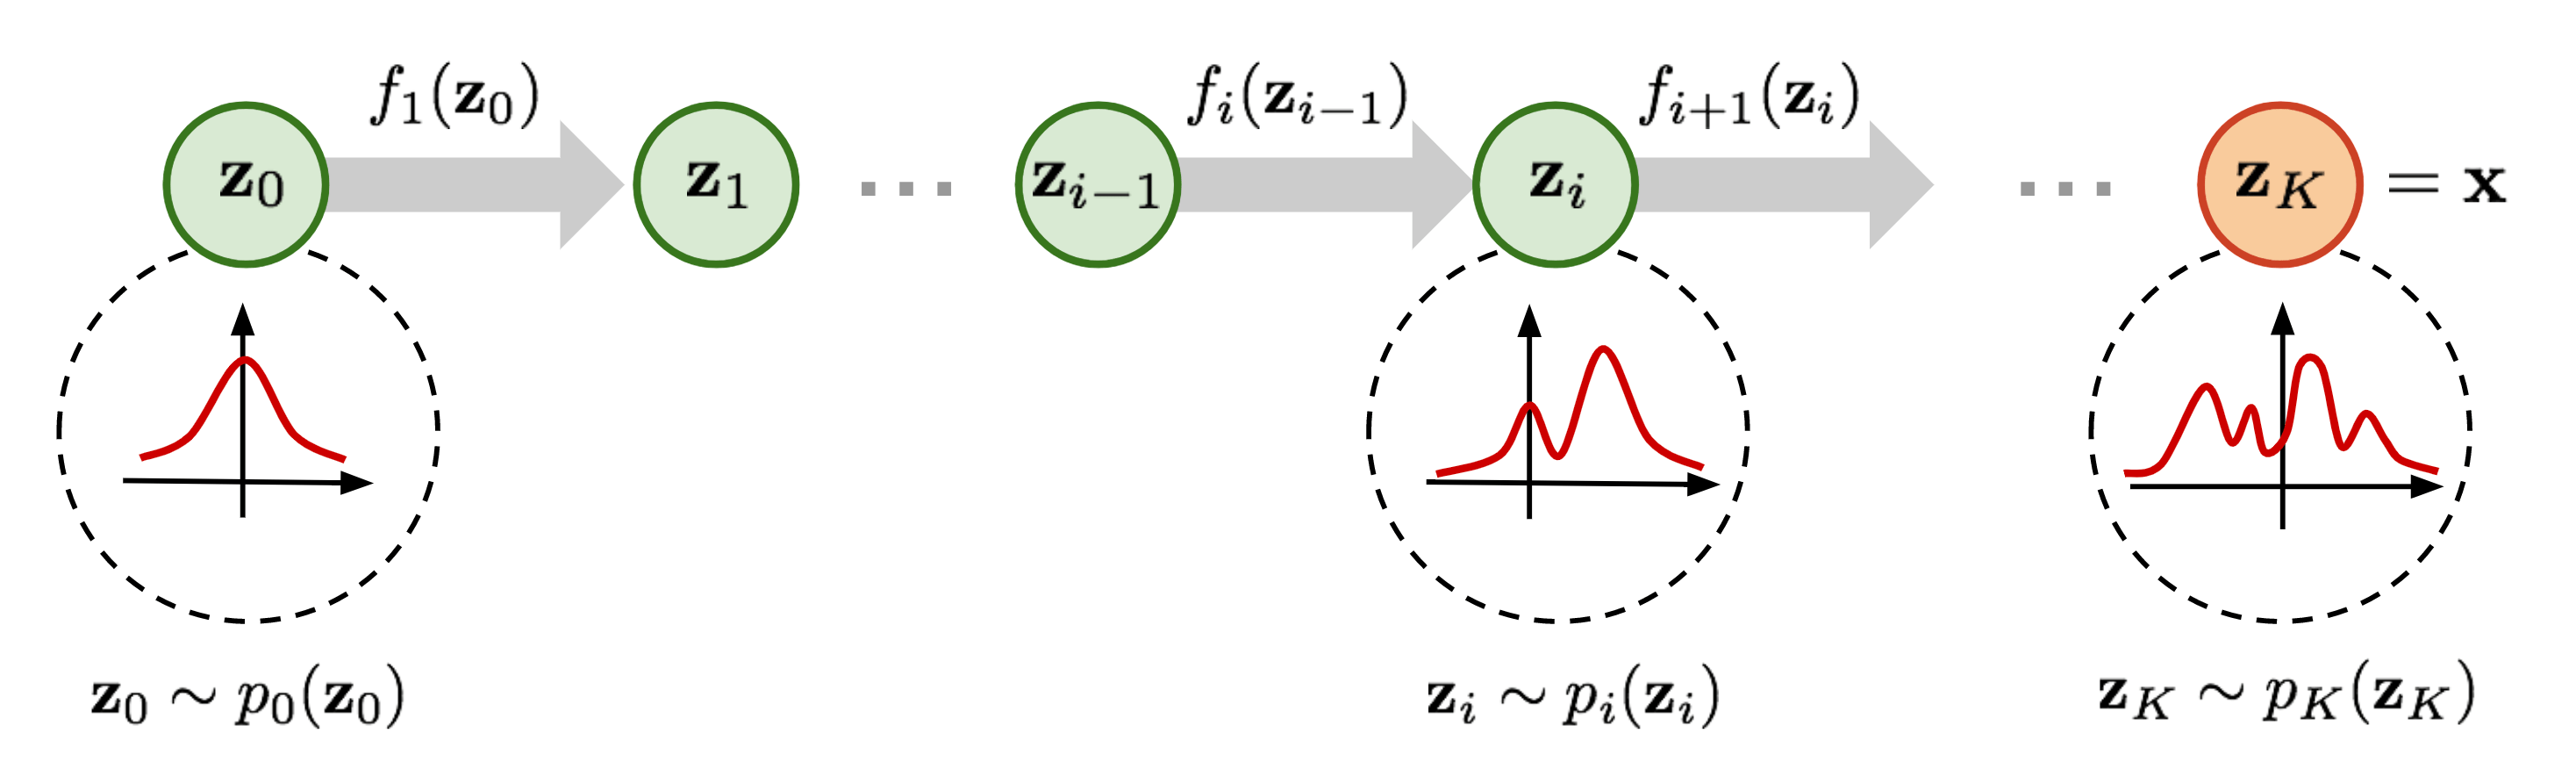

### Invertible mappings

Flows construct an **invertible** transformation

$$
f:\ \mathcal{X}\to\mathcal{Z},\qquad z=f(x)
$$

from data space $\mathcal{X}$ to a latent space $\mathcal{Z}$ endowed with a simple prior $p_Z(z)$ (e.g., standard Gaussian). Invertibility enforces **equal dimensionality**: $\dim(x)=\dim(z)$. Unlike VAEs—where $\dim(z)\ll \dim(x)$ is common—flows maintain a **bijective** mapping, enabling **lossless reconstruction**: for each sample $x$ there is a unique $z=f(x)$ and vice versa $x=f^{-1}(z)$. In the schematic above, this implies **zero reconstruction error** for flows, regardless of the specific invertible $f$ and input $x$.

### Exact density via change of variables

Let $z=f(x)$ with a differentiable bijection $f$. The **change-of-variables** formula gives the induced data density:

* **Univariate**:

  $$
  p_X(x) \;=\; p_Z\!\big(f(x)\big)\;\Bigl|\tfrac{\mathrm{d}}{\mathrm{d}x}f(x)\Bigr|.
  $$
* **Multivariate** ($x\in\mathbb{R}^d$):

  $$
  p_X(x) \;=\; p_Z\!\big(f(x)\big)\;\Bigl|\det J_f(x)\Bigr|,
  \quad
  J_f(x) \equiv \frac{\partial f(x)}{\partial x}\in\mathbb{R}^{d\times d}.
  $$

Taking logs (the usual training objective),

$$
\log p_X(x) \;=\; \log p_Z\!\big(f(x)\big) \;+\; \log\Bigl|\det J_f(x)\Bigr|.
$$

Thus, evaluating likelihoods reduces to (i) mapping $x\mapsto z$ and scoring under $p_Z$, and (ii) computing $\log|\det J_f(x)|$.

### Transforming densities and volume correction

View the flow **backwards**: start from a simple density $p_Z$ and push it through an invertible map $g=f^{-1}$ to synthesize data $x=g(z)$. Any invertible transformation **warps** the density while preserving total probability. For a simple translation $g(z)=z+1$, the shape shifts without volume change. For a scaling $g(z)=2z$, volumes change and heights adjust correspondingly; the **Jacobian determinant** provides the exact volume correction (figure credit: Eric Jang).

As transformations become more expressive, computing $g^{-1}$ and $\log|\det J_g|$ can become costly. Flows resolve this by **stacking** many simple, tractable, invertible maps:

$$
h_0=x,\quad h_k=f_k(h_{k-1}),\quad z=h_K,
$$

with each $f_k$ designed so that $f_k^{-1}$ and $\log|\det J_{f_k}|$ are cheap. The total log-likelihood decomposes as

$$
\log p_X(x)
\;=\;
\log p_Z(h_K) \;+\; \sum_{k=1}^{K}\log\bigl|\det J_{f_k}(h_{k-1})\bigr|.
$$

Planar and radial flows are early neural parameterizations of $f_k$. For high-dimensional data such as images, **coupling layers** (e.g., RealNVP) and **autoregressive** layers (e.g., MAF), often with **invertible $1\times 1$ convolutions** (Glow), provide scalable, tractable Jacobians.

### Flows for images

For image modeling, a flow maps an input image (e.g., MNIST) to a **same-shaped** latent tensor. This preserves exact invertibility and enables:

* **Density estimation**: forward pass $x\to z$, compute $\log p_Z(z)+\sum\log|\det J|$.
* **Sampling**: draw $z\sim p_Z$, then invert $z\to x=f^{-1}(z)$.

A practical flow implementation organizes:

* a forward routine that returns $\log p_X(x)$ (or NLL),
* an inverse routine for sampling,
* stable preprocessing (e.g., dequantization for discrete pixels),
* layers with tractable $\log|\det J|$ and efficient inverses.

![flowimages](image-2.png)


### Training, validation, and inference

During training and validation, flows operate in the **forward** direction to maximize the exact log-likelihood (equivalently, minimize NLL). At inference:

* **Likelihood queries** evaluate sample plausibility.
* **Generation** uses the inverse path to synthesize new samples.
* **Latent manipulations** are possible because $f$ is bijective.

